## Wealth Distribution Dynamics and Measures of Inequality

#### John Stachurski

This notebook gives an introduction to the evolution of weath distributions associated with different savings and income paths, along with related computational problems.

We focus on

* measures of inequality such as the Lorenz curve and Gini coefficient

* application of these measures to the wealth distribution generated by simulation

* how inequality is affected by different kinds of wage income and financial income.
    

We'll use plausible savings rules rather than compute them via an optimization problem in order to easily explore the implications of different assumptions on the exogenous processes.  

All of the techniques discussed here can be plugged into a model with optimization should you so desire.  

In [1]:
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt


### Lorenz Curves and Gini Coefficient



First let's use the algorithm described on the [Wikipedia page](https://en.wikipedia.org/wiki/Lorenz_curve) to build Lorenz curves:

In [2]:
@njit
def lorenz(y):
    n = len(y)
    y = np.sort(y)
    s = np.zeros(n+1)
    s[1:] = np.cumsum(y)
    y_cumulative_sum = 0.0
    f_vals = np.zeros(n+1)
    l_vals = np.zeros(n+1)
    for i in range(1, n+1):
        f_vals[i] = i/n
        l_vals[i] = s[i] / s[n]
    return f_vals, l_vals

Let's test our code on the Pareto distribution, where the shape of the Lorenz curve at different values of the parameter $a$ are described.

We'll test our function on a sample, rather than computing the population curves, so the match will not be exact.

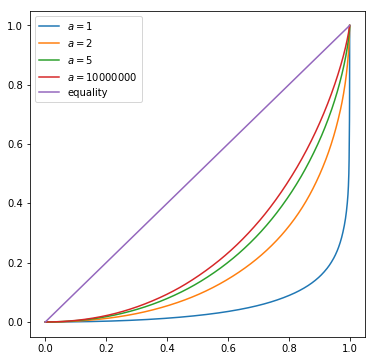

In [3]:
a_vals = (1, 2, 5, 10_000_000)
n = 10_000
fig, ax = plt.subplots(figsize=(6, 6))
for a in a_vals:
    y = np.random.pareto(a, size=n)
    f_vals, l_vals = lorenz(y)
    ax.plot(f_vals, l_vals, label=f'$a = {a}$')
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

Now let's write a function to compute the Gini coefficient.

Again, we use the [Wikipedia page](https://en.wikipedia.org/wiki/Gini_coefficient) for the definition.

We'll insert some parallelization because computational intensity is high for large samples.

In [4]:
@njit(parallel=True)
def gini(y):
    n = len(y)
    i_sum = np.zeros(n)
    for i in prange(n):
        for j in range(n):
            i_sum[i] += abs(y[i] - y[j])
    return np.sum(i_sum) / (2 * n * np.sum(y))

Let's test it on the Weibull distribution with parameter $a$, where the Gini coefficient is known to be

$$ G = 1 - 2^{-1/a} $$


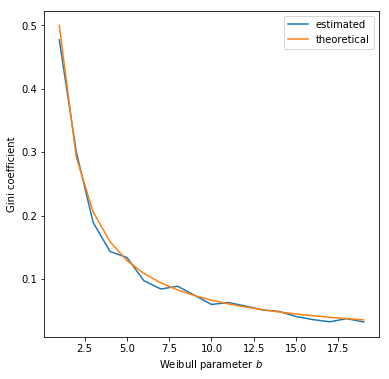

In [5]:
a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 100

fig, ax = plt.subplots(figsize=(6, 6))
for a in a_vals:
    y = np.random.weibull(a, size=n)
    ginis.append(gini(y))
    ginis_theoretical.append(1 - 2**(-1/a))
ax.plot(a_vals, ginis, label='estimated')
ax.plot(a_vals, ginis_theoretical, label='theoretical')
ax.legend()
ax.set_xlabel("Weibull parameter $b$")
ax.set_ylabel("Gini coefficient")
plt.show()

Here's another test, showing how the Gini coefficient varies across different parameterizations of the Pareto distribution.

For a Pareto distribution with parameter $a$, the Gini coefficient is known to be

$$ G = \frac{1}{2a - 1} $$

whenever $a > 1$.

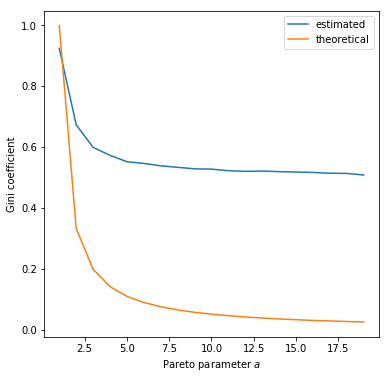

CPU times: user 53.9 s, sys: 10 ms, total: 53.9 s
Wall time: 7.58 s


In [6]:
%%time
a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 50_000

fig, ax = plt.subplots(figsize=(6, 6))
for a in a_vals:
    y = np.random.pareto(a, size=n)
    ginis.append(gini(y))
    ginis_theoretical.append(1 / (2*a - 1))
ax.plot(a_vals, ginis, label='estimated')
ax.plot(a_vals, ginis_theoretical, label='theoretical')
ax.legend()
ax.set_xlabel("Pareto parameter $a$")
ax.set_ylabel("Gini coefficient")
plt.show()

The estimated values are very biased, even with our huge sample size, suggesting the difficulty of accurately sampling Pareto distributions.

### A Model of Wealth Dynamics

The model we'll study is

$$ w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1} $$

where

* $w_t$ is wealth at time $t$ for a given household,
* $r_t$ is the rate of return of financial assets,
* $y_t$ is current non-financial (e.g., labor) income and
* $s(w_t)$ is current wealth net of consumption



Letting $\{z_t\}$ be a correlated state process of the form

$$ z_{t+1} = a z_t + b + \sigma_z \epsilon_{t+1} $$

we'll assume that

$$ R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t) $$

and 

$$ y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t) $$

Here $\{ (\epsilon_t, \xi_t, \zeta_t) \}$ is IID and standard normal in $\mathbb R^3$.

The value of $c_r$ should be close to zero, since rates of return on assets do not exhibit large trends.

When we simulate a population of households, we will take 

* $\{z_t\}$ to be an **aggregate shock** that is common to all households
* $\{\xi_t\}$ and $\{\zeta_t\}$ to be **idiosyncratic shocks** 

Idiosyncratic shocks are specific to individual households and independent across them.

Regarding the savings function $s$, our default model will be

$$ s(w) = s_0 w \mathbb 1\{\hat w \leq w\} $$

where $s_0$ is a fixed value.  Thus, for $w < \hat w$, the household saves nothing.  For $w \geq \bar w$, the household saves a fraction $s_0$ of their wealth.

Thus, we are using something akin to a fixed savings rate model, while acknowledging that low wealth households tend to save very little.

In [7]:
class WealthDynamics:
    
    def __init__(self,
                 w_hat=10.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.5,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.0,
                 σ_r=0.6,
                 a=0.9,
                 b=0.0,
                 σ_z=0.1):
    
        # The usual boilerplate
        self.w_hat, self.s_0 = w_hat, s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r, self.σ_r = c_r, μ_r, σ_r
        self.a, self.b, self.σ_z = a, b, σ_z
        
        # Record stationary moments
        self.z_mean = b / (1 - a)
        self.z_var = σ_z**2 / (1 - a**2)
        exp_z_mean = np.exp(self.z_mean + self.z_var / 2)
        self.R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
        self.y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)
        
        # Test stability condition, compute estimate of the stationary
        # mean of w_t
        α = self.R_mean * self.s_0
        if α < 1:
            print(f"Generated instance with stability coefficient α = {α}")
            self.w_bar = self.y_mean / (1 - α)
        else:
            raise ValueError(f"Stability condition failed with α = {α}")
            
    def parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.w_hat, self.s_0, 
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r, self.σ_r,
                      self.a, self.b, self.σ_z)
        return parameters
        
    def update_function_builder(self):
        """
        A function factory that returns a function with one task:
        update wealth from w_t to w_{t+1}.
        """
        # Unpack parameters
        params = self.parameters()
        w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, a, b, σ_z = params
                
        @njit
        def update_z(z):
            """
            Update exogenous state one period, given current state z.
            """   
            zp = a * z + b + σ_z * np.random.randn()
            return zp
        
        @njit
        def update_w(w, zp):
            """
            Update one period, given current wealth w and next period 
            exogenous state zp.
            """   
            y = c_y * np.exp(zp) + np.exp(μ_y + σ_y * np.random.randn())   
            wp = y
            if w >= w_hat:
                R = c_r * np.exp(zp) + np.exp(μ_r + σ_r * np.random.randn())
                wp += R * s_0 * w 
            return wp
        
        return update_z, update_w
    

In [8]:
@njit
def z_time_series(z_0, g, ts_length=10_000):
    """
    Generate a single time series of length ts_length for the 
    aggregate shock process {z_t}, given jitted update rule g.
    """
    z = np.empty(ts_length)
    z[0] = z_0
    for t in range(ts_length-1):
        z[t+1] = g(z[t])
    return z

In [9]:
@njit
def wealth_time_series(w_0, z, h):
    """
    Generate a single time series for wealth given aggregate shock sequence z.
    
    The returned time series w satisfies len(w) = len(z).
    """
    n = len(z)
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1] = h(w[t], z[t+1])
    return w

In [39]:
@njit
def cross_section(w_distribution, z, h):
    """
    Takes a current distribution of wealth values as w_distribution
    and, using update function h, updates each w_t in w_distribution 
    to w_{t+j}, where j = shift_length.  
    
    The value z_0 is the initial condition of the aggregate state.
    
    Returns the new distribution.
    """
    n = len(w_distribution)
    T = len(z)
    out_distribution = np.empty(n)
        
    # Update each household
    for i in range(n):
        w = w_distribution[i]
        for t in range(T-1):
            w = h(w, z[t+1])
        out_distribution[i] = w
        
    return out_distribution

### Application I:  Time Series

Let's look at the wealth dynamics of an individual household.  Large spikes are indicative of heavy tails.

Generated instance with stability coefficient α = 0.9967159264282274


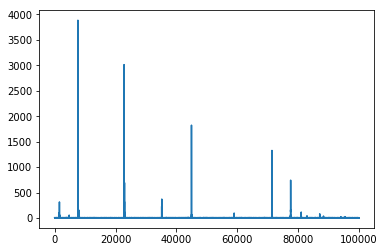

In [40]:
wd = WealthDynamics(σ_r=0.7)

g, h = wd.update_function_builder()
z = z_time_series(0.0, g, ts_length=100_000)
w = wealth_time_series(wd.y_mean, z, h)

fig, ax = plt.subplots()
ax.plot(w)
plt.show()

### Application II: Inequality Measures

Let's look at how inequality varies with returns on financial assets.

In [53]:
def generate_lorenz_and_gini(wd, num_households=250_000, T=500):
    """
    Generate the Lorenz curve data and gini coefficient corresponding to a 
    WealthDynamics mode by simulating num_households forward to time T.
    """
    ψ_0 = np.ones(num_households) * wd.y_mean
    z_0 = wd.z_mean

    g, h = wd.update_function_builder()
    z = z_time_series(z_0, g, ts_length=T)

    ψ_star = cross_section(ψ_0, z, h)
    return gini(ψ_star), lorenz(ψ_star)

Here's the Lorenz curves as a function of $\mu_r$, a parameter that shifts up mean returns.

Generated instance with stability coefficient α = 0.93641296386592
Generated instance with stability coefficient α = 0.9591437402469457
Generated instance with stability coefficient α = 0.9824499489716708


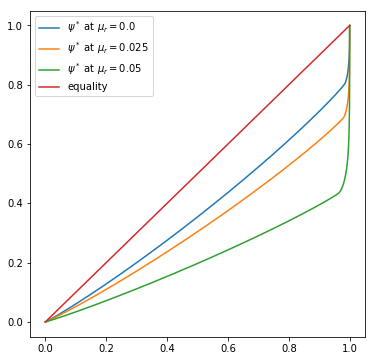

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))
μ_r_vals = np.linspace(0.0, 0.05, 3)
gini_vals = []

for μ_r in μ_r_vals:
    wd = WealthDynamics(μ_r=μ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wd)
    ax.plot(f_vals, l_vals, label=f'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(gv)
    
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

Here's the Gini coefficient.  Look how inequality.

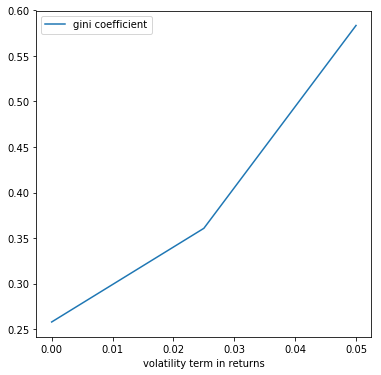

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))    
ax.plot(μ_r_vals, gini_vals, label='gini coefficient')
ax.set_xlabel("volatility term in returns")
ax.legend()
plt.show()